In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import time

from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d lishuyu/gsod-shanghaichina-5station-collections



Dataset URL: https://www.kaggle.com/datasets/lishuyu/gsod-shanghaichina-5station-collections
License(s): CC0-1.0
 37% 7.00M/18.7M [00:00<00:00, 68.8MB/s]
100% 18.7M/18.7M [00:00<00:00, 95.8MB/s]


In [ ]:
!mkdir -p climatology_dataset


In [ ]:
!unzip gsod-shanghaichina-5station-collections.zip -d climatology_dataset


Archive:  gsod-shanghaichina-5station-collections.zip
  inflating: climatology_dataset/47163099999.csv  
  inflating: climatology_dataset/47165099999.csv  
  inflating: climatology_dataset/47169099999.csv  
  inflating: climatology_dataset/47185043263.csv  
  inflating: climatology_dataset/54836099999.csv  
  inflating: climatology_dataset/54852599999.csv  
  inflating: climatology_dataset/54916099999.csv  
  inflating: climatology_dataset/54929099999.csv  
  inflating: climatology_dataset/54945099999.csv  
  inflating: climatology_dataset/58027099999.csv  
  inflating: climatology_dataset/58040099999.csv  
  inflating: climatology_dataset/58141099999.csv  
  inflating: climatology_dataset/58150099999.csv  
  inflating: climatology_dataset/58221099999.csv  
  inflating: climatology_dataset/58238099999.csv  
  inflating: climatology_dataset/58239099999.csv  
  inflating: climatology_dataset/58251099999.csv  
  inflating: climatology_dataset/58265099999.csv  
  inflating: climatology_dat

In [ ]:
print("Listing files in 'climatology_dataset' directory after extraction:")
for root, dirs, files in os.walk('climatology_dataset'):
    for filename in files:
        print(f"Found file: {os.path.join(root, filename)}")

Listing files in 'climatology_dataset' directory after extraction:
Found file: climatology_dataset/58754099999.csv
Found file: climatology_dataset/58321099999.csv
Found file: climatology_dataset/54929099999.csv
Found file: climatology_dataset/58424099999.csv
Found file: climatology_dataset/58715099999.csv
Found file: climatology_dataset/54836099999.csv
Found file: climatology_dataset/58150099999.csv
Found file: climatology_dataset/58238099999.csv
Found file: climatology_dataset/58472099999.csv
Found file: climatology_dataset/58457099999.csv
Found file: climatology_dataset/58659099999.csv
Found file: climatology_dataset/58265099999.csv
Found file: climatology_dataset/58834099999.csv
Found file: climatology_dataset/54916099999.csv
Found file: climatology_dataset/58646099999.csv
Found file: climatology_dataset/54852599999.csv
Found file: climatology_dataset/58477099999.csv
Found file: climatology_dataset/58027099999.csv
Found file: climatology_dataset/58633099999.csv
Found file: climatolo

In [ ]:
def load_data_from_folder(folder_path, file_extension='.csv'):  # Adjust extension as needed
    data_frames = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(file_extension):  # Adjust the extension as needed
                file_path = os.path.join(root, file)
                print(f"Loading {file_path}")
                df = pd.read_csv(file_path)  # Adjust parameters as needed
                data_frames.append(df)
    if not data_frames:
        raise ValueError(f"No {file_extension} files found in the specified folder.")
    return pd.concat(data_frames, ignore_index=True)

# Specify the folder containing the dataset
dataset_folder = 'climatology_dataset'
df = load_data_from_folder(dataset_folder)

Loading climatology_dataset/58754099999.csv
Loading climatology_dataset/58321099999.csv
Loading climatology_dataset/54929099999.csv
Loading climatology_dataset/58424099999.csv
Loading climatology_dataset/58715099999.csv
Loading climatology_dataset/54836099999.csv
Loading climatology_dataset/58150099999.csv
Loading climatology_dataset/58238099999.csv
Loading climatology_dataset/58472099999.csv
Loading climatology_dataset/58457099999.csv
Loading climatology_dataset/58659099999.csv
Loading climatology_dataset/58265099999.csv
Loading climatology_dataset/58834099999.csv
Loading climatology_dataset/54916099999.csv
Loading climatology_dataset/58646099999.csv
Loading climatology_dataset/54852599999.csv
Loading climatology_dataset/58477099999.csv
Loading climatology_dataset/58027099999.csv
Loading climatology_dataset/58633099999.csv
Loading climatology_dataset/58239099999.csv
Loading climatology_dataset/58040099999.csv
Loading climatology_dataset/58321199999.csv
Loading climatology_dataset/5836

In [ ]:
df

,Unnamed: 0,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,0,58754099999,1956-08-20,27.333333,120.200000,38.0,"FUDING, CH",81.2,6,74.7,...,8.0,NaN,95.0,,73.0,*,0.00,I,NaN,0
1,1,58754099999,1956-08-21,27.333333,120.200000,38.0,"FUDING, CH",84.7,7,75.6,...,8.0,NaN,95.0,,77.0,,0.02,A,NaN,10010
2,2,58754099999,1956-08-22,27.333333,120.200000,38.0,"FUDING, CH",83.8,6,77.3,...,12.0,NaN,95.0,,77.0,,0.00,I,NaN,0
3,3,58754099999,1956-08-23,27.333333,120.200000,38.0,"FUDING, CH",85.7,7,76.3,...,6.0,NaN,97.0,,79.0,,0.04,A,NaN,10
4,4,58754099999,1956-08-24,27.333333,120.200000,38.0,"FUDING, CH",81.1,7,75.6,...,9.9,NaN,91.0,,75.0,*,0.97,C,NaN,10010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749091,8424,47169099999,2024-08-16,34.687176,125.451042,68.5,"HEUKSANDO, KS",83.6,24,76.0,...,7.0,NaN,92.1,*,77.9,,0.00,I,NaN,0
749092,8425,47169099999,2024-08-17,34.687176,125.451042,68.5,"HEUKSANDO, KS",84.5,24,75.7,...,5.8,NaN,93.9,*,77.7,,0.00,I,NaN,0
749093,8426,47169099999,2024-08-18,34.687176,125.451042,68.5,"HEUKSANDO, KS",84.7,24,76.1,...,8.9,NaN,94.8,*,77.5,,0.00,I,NaN,0
749094,8427,47169099999,2024-08-19,34.687176,125.451042,68.5,"HEUKSANDO, KS",83.8,24,77.3,...,15.0,NaN,90.9,*,78.3,,0.00,I,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749096 entries, 0 to 749095
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        749096 non-null  int64  
 1   STATION           749096 non-null  int64  
 2   DATE              749096 non-null  object 
 3   LATITUDE          749096 non-null  float64
 4   LONGITUDE         749096 non-null  float64
 5   ELEVATION         749096 non-null  float64
 6   NAME              749096 non-null  object 
 7   TEMP              749096 non-null  float64
 8   TEMP_ATTRIBUTES   749096 non-null  int64  
 9   DEWP              748511 non-null  float64
 10  DEWP_ATTRIBUTES   749096 non-null  int64  
 11  SLP               691677 non-null  float64
 12  SLP_ATTRIBUTES    749096 non-null  int64  
 13  STP               288407 non-null  float64
 14  STP_ATTRIBUTES    749096 non-null  int64  
 15  VISIB             746218 non-null  float64
 16  VISIB_ATTRIBUTES  74

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
STATION,0
DATE,0
LATITUDE,0
LONGITUDE,0
ELEVATION,0
NAME,0
TEMP,0
TEMP_ATTRIBUTES,0
DEWP,585


In [ ]:
# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Handle missing values
df['DEWP'].fillna(df['DEWP'].median(), inplace=True)
df['SLP'].fillna(df['SLP'].median(), inplace=True)
df['STP'].fillna(df['STP'].median(), inplace=True)
df['VISIB'].fillna(df['VISIB'].median(), inplace=True)
df['WDSP'].fillna(df['WDSP'].median(), inplace=True)
df['MXSPD'].fillna(df['MXSPD'].median(), inplace=True)
df['GUST'].fillna(df['GUST'].median(), inplace=True)
df['MAX'].fillna(df['MAX'].median(), inplace=True)
df['MIN'].fillna(df['MIN'].median(), inplace=True)
df['SNDP'].fillna(df['SNDP'].median(), inplace=True)

# Drop columns that may not be needed for modeling or have too many missing values
df.drop(['Unnamed: 0',  'TEMP_ATTRIBUTES', 'DEWP_ATTRIBUTES', 'SLP_ATTRIBUTES',
         'STP_ATTRIBUTES', 'VISIB_ATTRIBUTES', 'WDSP_ATTRIBUTES', 'MXSPD', 'GUST',
         'MAX_ATTRIBUTES', 'MIN_ATTRIBUTES', 'PRCP_ATTRIBUTES', 'SNDP'], axis=1, inplace=True)

# Add temporal features
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['WEEKDAY'] = df['DATE'].dt.weekday



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'NAME' column
df['NAME'] = label_encoder.fit_transform(df['NAME'])

# Display the updated DataFrame
print(df)


            STATION       DATE   LATITUDE   LONGITUDE  ELEVATION  NAME  TEMP  \
0       58754099999 1956-08-20  27.333333  120.200000       38.0     8  81.2   
1       58754099999 1956-08-21  27.333333  120.200000       38.0     8  84.7   
2       58754099999 1956-08-22  27.333333  120.200000       38.0     8  83.8   
3       58754099999 1956-08-23  27.333333  120.200000       38.0     8  85.7   
4       58754099999 1956-08-24  27.333333  120.200000       38.0     8  81.1   
...             ...        ...        ...         ...        ...   ...   ...   
749091  47169099999 2024-08-16  34.687176  125.451042       68.5    10  83.6   
749092  47169099999 2024-08-17  34.687176  125.451042       68.5    10  84.5   
749093  47169099999 2024-08-18  34.687176  125.451042       68.5    10  84.7   
749094  47169099999 2024-08-19  34.687176  125.451042       68.5    10  83.8   
749095  47169099999 2024-08-20  34.687176  125.451042       68.5    10  82.3   

        DEWP     SLP     STP  VISIB  WD

In [ ]:
for column in df.columns:
  print(f"Column: {column}")
  print(df[column].head(10))  # Show the first 10 values for each column
  print("\n")


Column: STATION
0    58754099999
1    58754099999
2    58754099999
3    58754099999
4    58754099999
5    58754099999
6    58754099999
7    58754099999
8    58754099999
9    58754099999
Name: STATION, dtype: int64


Column: DATE
0   1956-08-20
1   1956-08-21
2   1956-08-22
3   1956-08-23
4   1956-08-24
5   1956-08-25
6   1956-08-26
7   1956-08-27
8   1956-08-28
9   1956-08-29
Name: DATE, dtype: datetime64[ns]


Column: LATITUDE
0    27.333333
1    27.333333
2    27.333333
3    27.333333
4    27.333333
5    27.333333
6    27.333333
7    27.333333
8    27.333333
9    27.333333
Name: LATITUDE, dtype: float64


Column: LONGITUDE
0    120.2
1    120.2
2    120.2
3    120.2
4    120.2
5    120.2
6    120.2
7    120.2
8    120.2
9    120.2
Name: LONGITUDE, dtype: float64


Column: ELEVATION
0    38.0
1    38.0
2    38.0
3    38.0
4    38.0
5    38.0
6    38.0
7    38.0
8    38.0
9    38.0
Name: ELEVATION, dtype: float64


Column: NAME
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8 

In [ ]:
df['WEEKDAY']

,WEEKDAY
0,0
1,1
2,2
3,3
4,4
...,...
749091,4
749092,5
749093,6
749094,0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 139s 69ms/step - loss: 0.2757 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 2/5
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - loss: 0.0293 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 3/5
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 140s 72ms/step - loss: 0.0255 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 4/5
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 130s 67ms/step - loss: 0.0249 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 5/5
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 138s 65ms/step - loss: 0.0241 - val_loss: 0.0141 - learning_rate: 0.0010
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0140
Test Loss: 0.014062300324440002


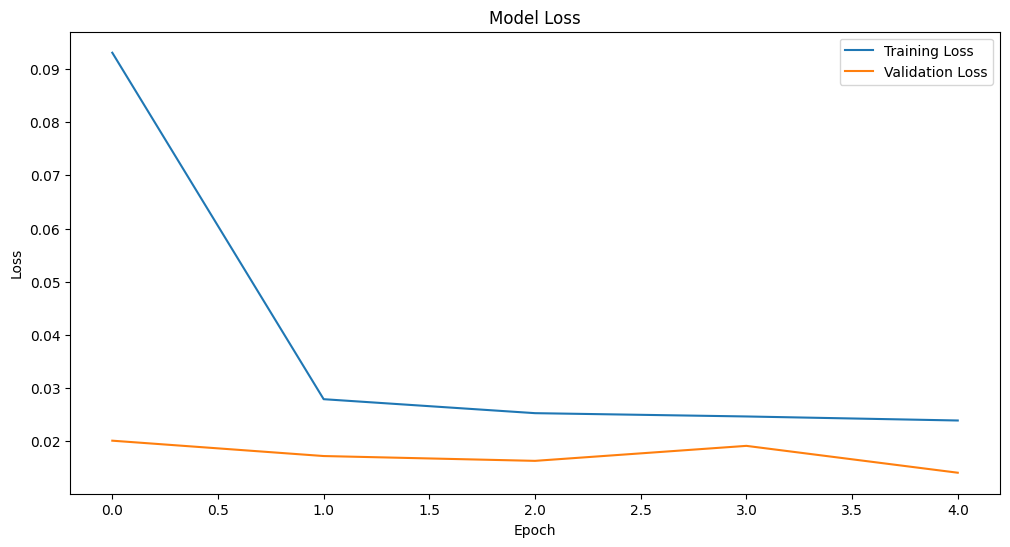

Epoch 1/5
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 241s 61ms/step - loss: 0.1782 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 2/5
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 256s 59ms/step - loss: 0.0250 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 3/5
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 263s 59ms/step - loss: 0.0228 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 4/5
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 262s 60ms/step - loss: 0.0219 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 5/5
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 227s 58ms/step - loss: 0.0214 - val_loss: 0.0171 - learning_rate: 0.0010
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0147
Test Loss: 0.014124162495136261


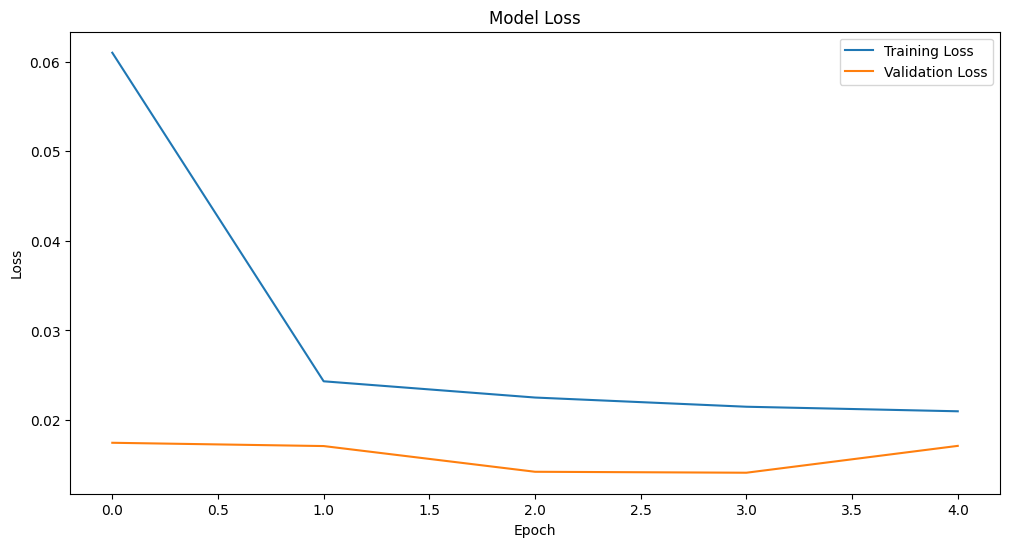

Epoch 1/5
5853/5853 ━━━━━━━━━━━━━━━━━━━━ 325s 55ms/step - loss: 0.1351 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 2/5
5853/5853 ━━━━━━━━━━━━━━━━━━━━ 340s 58ms/step - loss: 0.0241 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 3/5
5853/5853 ━━━━━━━━━━━━━━━━━━━━ 322s 55ms/step - loss: 0.0221 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 4/5
5853/5853 ━━━━━━━━━━━━━━━━━━━━ 310s 53ms/step - loss: 0.0212 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 5/5
5853/5853 ━━━━━━━━━━━━━━━━━━━━ 323s 53ms/step - loss: 0.0203 - val_loss: 0.0117 - learning_rate: 0.0010
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0116
Test Loss: 0.011658767238259315


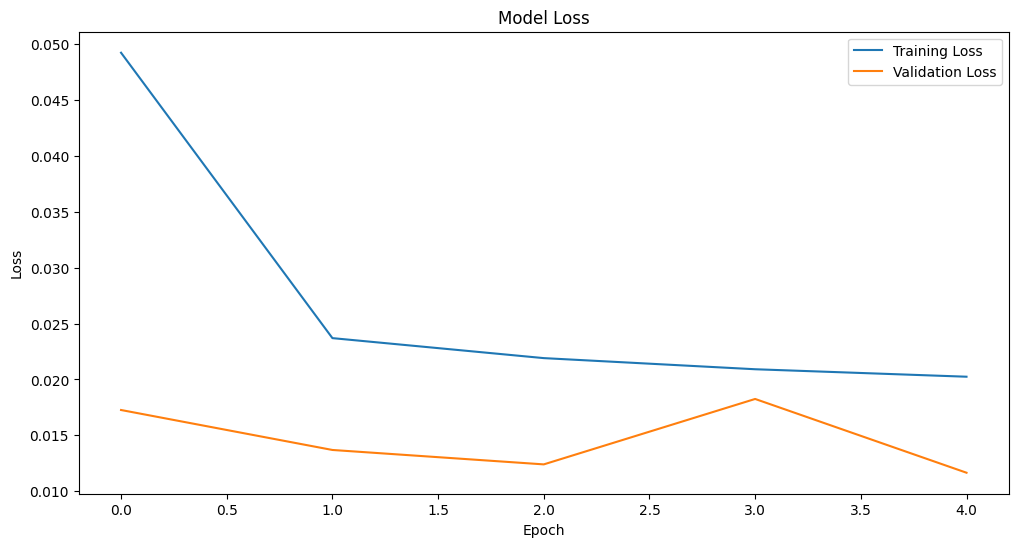

Epoch 1/5
7804/7804 ━━━━━━━━━━━━━━━━━━━━ 410s 52ms/step - loss: 0.1125 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 2/5
7804/7804 ━━━━━━━━━━━━━━━━━━━━ 454s 54ms/step - loss: 0.0229 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 3/5
7804/7804 ━━━━━━━━━━━━━━━━━━━━ 429s 52ms/step - loss: 0.0210 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 4/5
7804/7804 ━━━━━━━━━━━━━━━━━━━━ 441s 52ms/step - loss: 0.0205 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 5/5
7804/7804 ━━━━━━━━━━━━━━━━━━━━ 456s 54ms/step - loss: 0.0199 - val_loss: 0.0136 - learning_rate: 0.0010
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0166
Test Loss: 0.013562682084739208


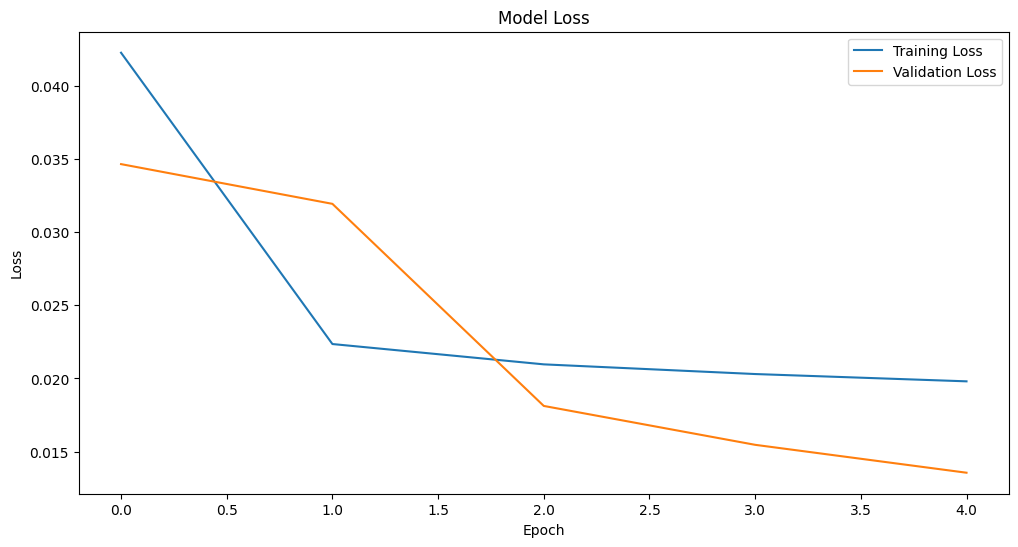

Epoch 1/5
9754/9754 ━━━━━━━━━━━━━━━━━━━━ 509s 52ms/step - loss: 0.1000 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 2/5
9754/9754 ━━━━━━━━━━━━━━━━━━━━ 562s 52ms/step - loss: 0.0228 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/5
9754/9754 ━━━━━━━━━━━━━━━━━━━━ 564s 52ms/step - loss: 0.0208 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 4/5
9754/9754 ━━━━━━━━━━━━━━━━━━━━ 536s 55ms/step - loss: 0.0201 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 5/5
9754/9754 ━━━━━━━━━━━━━━━━━━━━ 557s 54ms/step - loss: 0.0196 - val_loss: 0.0102 - learning_rate: 0.0010
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0086
Test Loss: 0.009901138022542


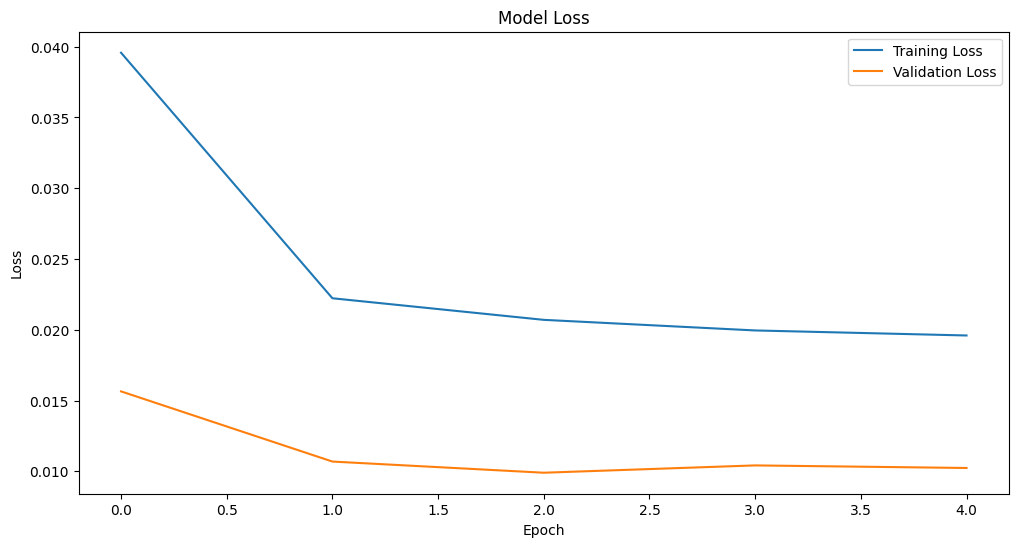

23410/23410 ━━━━━━━━━━━━━━━━━━━━ 188s 8ms/step - loss: 0.0109
Final Model Test Loss: 0.010909422300755978


In [15]:
# Define features and target
features = ['DEWP', 'SLP', 'NAME','STP', 'VISIB', 'WDSP', 'MAX', 'MIN', 'PRCP', 'MONTH', 'DAY', 'WEEKDAY'] # Change features to a list
target = 'TEMP' # Change target to a string

X = df[features].values
y = df[target].values

# Scaling data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Define a function to create and compile the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape, return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(GRU(64, return_sequences=False, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)

# Tracking best performance
best_loss = float('inf')

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # Build model
    model = build_gru_model((X_train.shape[1], 1))

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Reshape data for GRU input
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    # Track the best loss
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Final evaluation on the best model
X_scaled = np.expand_dims(X_scaled, axis=2)
final_loss = best_model.evaluate(X_scaled, y_scaled)
print(f'Final Model Test Loss: {final_loss}')

# Save the best model
best_model.save('best_gru_model.keras')

In [19]:
import pickle

# Save the scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

best_model.save('best_gru_model.keras')


In [20]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np

# Load the saved model
model = load_model('best_gru_model.keras')

# Load the scaler
with open('scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)


def make_prediction(dewp, slp, name, stp, visib, wdsp, max_temp, min_temp, prcp, month, day, weekday):
  """Makes a prediction using the loaded model and scaler."""
  # Convert 'name' to numerical using label encoder
  name_encoded = label_encoder.transform([name])[0]

  # Create input array
  input_data = np.array([[dewp, slp, name_encoded, stp, visib, wdsp, max_temp, min_temp, prcp, month, day, weekday]])

  # Scale the input data
  input_scaled = scaler_X.transform(input_data)

  # Reshape for GRU input
  input_scaled = np.expand_dims(input_scaled, axis=2)

  # Make prediction
  prediction_scaled = model.predict(input_scaled)

  # Inverse transform the prediction
  prediction = scaler_y.inverse_transform(prediction_scaled)

  return prediction[0][0]

# Example usage:
# Get user input (you'll need to implement the actual input method, e.g., using input() or a form)

dewp = float(input("Enter DEWP: "))
slp = float(input("Enter SLP: "))
name = input("Enter Station Name: ")  # e.g., 'Shanghai')
stp = float(input("Enter STP: "))
visib = float(input("Enter VISIB: "))
wdsp = float(input("Enter WDSP: "))
max_temp = float(input("Enter MAX: "))
min_temp = float(input("Enter MIN: "))
prcp = float(input("Enter PRCP: "))
month = int(input("Enter Month (1-12): "))
day = int(input("Enter Day (1-31): "))
weekday = int(input("Enter Weekday (0-6): "))


# Make prediction
predicted_temp = make_prediction(dewp, slp, name, stp, visib, wdsp, max_temp, min_temp, prcp, month, day, weekday)
print(f"Predicted Temperature: {predicted_temp}")




Enter DEWP: 34.7
Enter SLP: 1023.0
Enter Station Name: FUDING, CH
Enter STP: 1008.2
Enter VISIB: 18.3
Enter WDSP: 7.5
Enter MAX: 45.0
Enter MIN: 30.0
Enter PRCP: 0.00
Enter Month (1-12): 1
Enter Day (1-31): 12
Enter Weekday (0-6): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicted Temperature: 39.32701873779297
